# Three level system

In [53]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate, basis
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt

import UD_liouv as RC
import driving_liouv as EM
import exact_IB as exact
import scipy as sp

import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard, J_multipolar

import spectra_functions as SF

reload(RC)
reload(EM)
reload(exact)
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

# Things that will always be true
ev_to_inv_cm = 8065.5
inv_ps_to_inv_cm = 5.309
G = basis(3,0)
XO = basis(3,1)
OX = basis(3,2)
ground = G*G.dag()
site1 = XO*XO.dag()
site2 = OX*OX.dag()

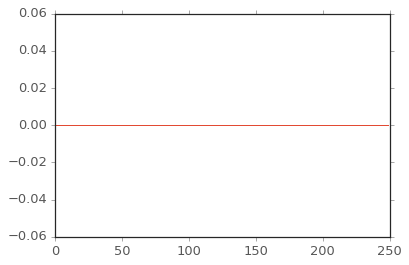

[    0.            0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.            0.
     0.            0.            0.         8053.2864615  8053.2864615
  8053.2864615  8053.2864615  8053.2864615  8053.2864615  8053.2864615
  8053.2864615  8053.2864615  8053.2864615  8053.2864615  8053.2864615
  8053.2864615  8053.2864615  8053.2864615  8884.2635385  8884.2635385
  8884.2635385  8884.2635385  8884.2635385  8884.2635385  8884.2635385
  8884.2635385  8884.2635385  8884.2635385  8884.2635385  8884.2635385
  8884.2635385  8884.2635385  8884.2635385]
It took  0.718780994415  seconds to build the vibronic Lindblad Liouvillian
(45, 45) (3, 3)
Calculating non-RWA Liouvilliian took 3.17561793327 seconds.
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj da

KeyboardInterrupt: 

In [129]:
N = 15
mu1 = 1.
mu2 = 1.

def make_vibronic(op, N):
    return tensor(op, qeye(N))
a = destroy(N)

sigma = G*XO.dag() + mu1*G*OX.dag()# Definition of a sigma_- operator.
sigma_x = sigma + sigma.dag()
sigma_z = site1 + site2

A_ph = tensor(qeye(3), (a + a.dag()))

#print sigma_x, sigma_z
J_EM = J_multipolar#EM.J_minimal




w1 = 1*ev_to_inv_cm
w2 = 1.1*ev_to_inv_cm
V = 0.
T_ph = 300.
T_EM = 100.
H = w1*site1 + w2*site2 + V*(XO*OX.dag()+OX*XO.dag())
mu = np.sqrt(4*V**2 + (w2-w1)**2)
Gamma, alpha_ph, wRC= 10., 0.1*(w1+w2)/2, 2*mu


def vib_ham(w1, w2, Gamma, alpha_ph, wRC, T_ph):
    gamma = Gamma / (2. * np.pi * wRC)  # coupling between RC and residual bath
    kappa= np.sqrt(np.pi * alpha_ph * wRC / 2.)
    shift = (kappa**2)/wRC 
    H_RC = tensor((w1+shift)*site1+(w2+shift)*site2+ V*(XO*OX.dag()+OX*XO.dag()), qeye(N))
    H_RC += kappa*tensor(site1, (a + a.dag()))+kappa*tensor(site2, (a + a.dag()))
    H_RC += tensor(qeye(3),wRC*a.dag()*a)
    return H_RC, gamma, kappa

H_RC, gamma, kappa = vib_ham(w1, w2, Gamma, alpha_ph, wRC, T_ph)
L_RC, Z =  RC.liouvillian_build(H_RC, A_ph, gamma, wRC, T_ph)
superpos = 0.5*(XO+OX)*(OX+XO).dag()
rho0 = tensor(superpos, basis(N,0)*basis(N,0).dag())

# H, rho0, tlist, c_ops=[], e_ops=[]

plt.plot(data.expect[0])
plt.show()
S_plus, S_minus, S_0 = EM.RWA_system_ops(H_RC, make_vibronic(sigma_x, N))


H_lim =  make_vibronic(H, N) # vib_ham(w1, w2, Gamma, 0., wRC, T_ph)[0] #
print H_lim.eigenenergies()

Gamma_EM = 1.
L_add = EM.L_vib_lindblad(H_lim, make_vibronic(sigma ,N), (w1+w2)/2., 
                          Gamma_EM, T_EM, J_EM, time_units='cm', silent=False)
print H_RC.shape, sigma_x.shape
L_full = EM.L_non_rwa(H_RC, make_vibronic(sigma_x, N), (w1+w2)/2, Gamma_EM, T_EM, J_EM)
print steadystate(H_RC, [L_RC+L_full]).ptrace(0)
print steadystate(H_RC, [L_RC+L_add]).ptrace(0)
times = np.linspace(0, 8., 450)
opts = qt.Options(nsteps=1500)
"""data1 = mesolve(H_RC, rho0, times, [L_RC+L_full], [make_vibronic(site2, N)], options=opts)
data2 = mesolve(H_RC, rho0, times, [L_RC+L_add], [make_vibronic(site2, N)], options=opts)
plt.plot(times, data1.expect[0])
plt.plot(times, data2.expect[0])
plt.show()"""

In [131]:
def emission_spectra(init_sys, init_RC, w0_prop=2.1,
                    T_ph=300., T_EM=0.,Gamma_EM=1., overdamped=False, N=9,
                    end_T_mult=10, tau_f_mult=1., per_tau=1.):
    wc = 53.
    # Start system+RC in adiabatic eigenstate and then time-evolve
    plt.close('all')
    J = J_multipolar
    count = 1
    I_RC = qt.qeye(N)
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dyn_DATA = []
    
    # work out how to initialise system rho
    superpos = 0.5*(XO+OX)*(OX+XO).dag()
    init_rho = tensor(superpos, basis(N,0)*basis(N,0).dag())
    label = ['Naive', 'Full']
    #print len(excited_list), 'excited'
    # electromagnetic bath liouvillians
    final_t = end_T_mult/Gamma_EM
    timelist = np.linspace(0,final_t,int(380*final_t))
    options = qt.Options(nsteps=6000, store_states=True)
    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,6))
    L = [EM.L_vib_lindblad(H_lim, make_vibronic(sigma ,N), (w1+w2)/2., Gamma_EM, T_EM, J=J, silent=True),
                        EM.L_non_rwa(H_RC, make_vibronic(sigma_x ,N), (w1+w2)/2., Gamma_EM, T_EM, J, silent=True)]
    for i, L_EM in enumerate(L):
        #L_EM = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J, silent=True)
        ti = time.time()
        if label[i]=='Full':
            sigma_plus_RC, sigma_RC, sigma_0_RC = EM.RWA_system_ops(H_RC, tensor(sigma_x, I_RC))
            ls = 'solid'
        else:
            sigma_RC = make_vibronic(sigma ,N)
            ls = 'dashed'
        P = mesolve(H_RC, init_rho, timelist, [L_RC+L_EM], progress_bar=None,options=options).states

        ax1.plot(timelist, [((make_vibronic(site2, N)*p).tr()).real for p in P], label=label[i], linestyle=ls)
        steps_per_tau, tau_f = 1500*per_tau,  1.1
        '''if overdamped:
            steps_per_tau, tau_f = 1500*per_tau,  1.1
        else:
            if abs((w0-eps)/eps)<0.1:
                steps_per_tau, tau_f = 2000*per_tau, 2.1
            else:
                steps_per_tau, tau_f = 2000*per_tau, 1.1'''
        tau_f*=tau_f_mult
        #norm = np.array([(sigma_RC.dag()*sigma_RC*rho_t).tr() for rho_t in P])[0:tau_f*steps_per_tau]
        R= sum(P)
        print "Completed initial dynamics calculations for {} in {} seconds.".format(label[i], time.time()-ti)
        ti = time.time()
        Lambda_0 = sigma_RC*R
        del P

        taulist = np.linspace(0, tau_f, int(tau_f*steps_per_tau))
        Lambda_t = mesolve(H_RC, Lambda_0, taulist, [L_RC+L_EM],options=options)
        #sigma_t = mesolve(H_RC, init_rho, taulist, [L_RC+L_EM],
        #                  [sigma_RC.dag()*sigma_RC], options=options).expect[0]
        g_1 = np.array([(sigma_RC.dag()*l).tr() for l in Lambda_t.states])
        g_1/=abs(g_1[0])
        #else:
        #    g_1/=np.sqrt(norm*norm[0])

        #if label[i] == 'Full':
        #    g_1=g_1.conjugate()

        ax3.plot(taulist[0:int(tau_f*steps_per_tau/2.)],
                 g_1.real[0:int(tau_f*steps_per_tau/2.)], label=label[i], linestyle=ls)
        ax4.plot(taulist[0:int(tau_f*steps_per_tau/2.)],
                 g_1.imag[0:int(tau_f*steps_per_tau/2.)], label=label[i], linestyle=ls)
        freq, spec = qt.spectrum_correlation_fft(taulist, g_1)
        spec-= min(spec)
        spec = spec/sum(spec)
        ax2.plot(freq, spec.real, label=label[i], linestyle=ls)
        print "Completed correlation function calculations for {} in {} seconds.".format(label[i], time.time()-ti)
    ax1.set_xlim(0,final_t)
    #ax3.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    #ax4.set_xlim(0,taulist[int((len(taulist)-1)/5.)])
    ax1.set_xlabel(r"Time")
    ax2.set_xlabel(r"Frequency $cm^{-1}$")
    #ax2.axvline(eps, linestyle='dashed',color='k', alpha=0.4)
    #ax2.set_xlim(0,2*w2)

    ax1.set_ylabel(r"Excited state population")
    ax2.set_ylabel(r"Fluorescence intensity (arb. units)")
    ax3.set_ylabel(r"$Re[g_1(\tau)]$") # coherence
    ax4.set_ylabel(r"$Im[g_1(\tau)]$") # coherence
    ax3.set_xlabel(r"$\tau$")
    ax4.set_xlabel(r"$\tau$")
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()
    return freq, spec

freq, spec = emission_spectra(1, 0, w0_prop=0.025,
                    T_ph=300., T_EM=0.,Gamma_EM=1., overdamped=False, N=N,
                    end_T_mult=10, tau_f_mult=3., per_tau=1.)

KeyboardInterrupt: 

In [ ]:
def dynamics_plotter(eps=1000., T_ph=300., w0_prop=0.1, alpha_prop=0.1, 
                     Gamma_prop=0.1, T_EM=0., Gamma_EM_prop=0.005, N = 25):
    
    Gamma, w0, alpha_ph, Gamma_EM = Gamma_prop*eps, w0_prop*eps, alpha_prop*eps, Gamma_EM_prop*eps
    L_RC, H_RC, A_EM, A_nrwa, _, _, _, _ = RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, alpha_ph, N)

    S_plus, S_minus, S_0 = EM.RWA_system_ops(H_RC, A_nrwa)
    L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J=J_EM)
    L_vib_ns = EM.L_nonsecular(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM)
    L_vib_s = EM.L_vib_lindblad(H_RC, S_minus, eps, Gamma_EM, T_EM, J=J_EM)
    L_em_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_em_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J_EM, silent=True)
    L_em = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J_EM, silent=True)
    expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag()+G*E.dag(), qeye(N)), 
                   tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
                   tensor(qeye(2), destroy(N).dag()+destroy(N))]
    n_RC = EM.Occupation(w0, T_ph)
    rho_0 = tensor(E*E.dag(), thermal_dm(N, n_RC))
    #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
    #print H_RC.eigenenergies()
    #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
    DATA_rig = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_ns], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real
    DATA_nrwa = mesolve(H_RC, rho_0, timelist, [L_RC+L_nrwa], 
                          expects, options=qt.Options(nsteps=1000), progress_bar=True).expect[0].real
    DATA_rigsec = mesolve(H_RC, rho_0, timelist, [L_RC+L_vib_s], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    DATA_nonrig = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_ns], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    DATA_ESA = mesolve(H_RC, rho_0, timelist, [L_RC+L_em], 
                          expects, options=qt.Options(nsteps=1000)).expect[0].real
    #DATA_nonrig_sec = mesolve(H_RC, rho_0, timelist, [L_RC+L_em_s], 
    #                      expects, options=qt.Options(nsteps=1000)).expect[0].real
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    plt.xlim(timelist[0], timelist[-1])
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    plt.ylim(0.,0.3)
    plt.xlim(0.,0.05)
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    #
    plt.figure(figsize=(10,6))
    plt.plot(timelist, DATA_nrwa, label='non RWA', ls='dashed', linewidth=1.6)
    plt.plot(timelist, DATA_rig, label='RWA', linewidth=1.)
    plt.plot(timelist, DATA_rigsec, label='RWA sec', ls='dashed',linewidth=1.0)
    plt.plot(timelist, DATA_nonrig, label='naive RWA')
    plt.plot(timelist, DATA_ESA, label='naive ESA')
    #plt.plot(timelist, DATA_nonrig, label='naive RWA sec', ls='dashed', linewidth=1.6)
    plt.legend(loc='best')
    plt.xlim(timelist[-1]-0.2,timelist[-1])
    plt.ylabel('Ground Population')
    plt.xlabel('Time')
    plt.show()
    
dynamics_plotter(alpha_prop=0.5, w0_prop=0.99, N=12)